<a href="https://colab.research.google.com/github/dastias/Projeto-doutorado/blob/main/Analise_Redes_Neurais_KDE%2C_MSC%2C_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import stft
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from scipy.fft import fft, ifft,rfft,irfft
from sklearn.cluster import estimate_bandwidth
import pywt

MessageError: Error: credential propagation was unsuccessful

### Carrega Dados Padrão

In [ ]:
dados_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_NOR.csv')
dados_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_BEA.csv')


In [ ]:
dados_mis = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_MIS.csv')
dados_unb = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_UNB.csv')

### Carrega Dados Filtrados Wave

In [ ]:
wave_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_normal.csv')
wave_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_bea.csv')

### Carrega Dados Filtrados KDE

In [ ]:
KDE_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/KDE_normal.csv')
KDE_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/KDE_bea.csv')

### Carrega Dados Filtrados MSC

In [ ]:
MSC_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/normal_filtrado_MSC_50.csv')
MSC_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/bea_filtrado_MSC_50.csv')

### Carrega Dados Wave + KDE

In [ ]:
Wave_KDE_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_KDE_normal.csv')
Wave_KDE_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_KDE_bea.csv')

### Carrega Dados Wave + MSC

### Definição de Features

In [ ]:
def FFT(data):
    '''FFT process and filtering'''
    data = np.asarray(data)
    fft = abs(rfft(data))
    return fft

In [ ]:
def mean(data):
    '''Mean features'''
    data = np.asarray(data)
    M = pd.DataFrame(np.mean(data, axis=1))
    return M

In [ ]:
def pp(data):
    '''Peak-to-Peak features'''
    data = np.asarray(data)
    PP = pd.DataFrame(np.max(data, axis=1) - np.min(data, axis=1))
    return PP

In [ ]:
def rms(data):
    '''RMS features'''
    data = np.asarray(data)
    Rms = pd.DataFrame(np.sqrt(np.mean(data**2, axis=1)))
    return Rms

### Features Dados Originais

In [ ]:
fft_normal = pd.DataFrame(FFT(dados_normal.iloc[:50]))
fft_bea = pd.DataFrame(FFT(dados_bea.iloc[:50]))
fft_mis = pd.DataFrame(FFT(dados_mis.iloc[:50]))
fft_unb = pd.DataFrame(FFT(dados_unb.iloc[:50]))

In [ ]:
data_merged = pd.concat((fft_normal, fft_bea,fft_mis,fft_unb))

In [ ]:
def NormalizeData(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged)
    data_min = np.min(data_merged)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))

In [ ]:
fft_normal_norm = NormalizeData(fft_normal)
fft_bea_norm = NormalizeData(fft_bea)
fft_mis_norm = NormalizeData(fft_mis)
fft_unb_norm = NormalizeData(fft_unb)

In [ ]:
media_normal = mean(fft_normal_norm)
media_bea = mean(fft_bea_norm)
media_mis = mean(fft_mis_norm)
media_unb = mean(fft_unb_norm)
pp_normal = pp(fft_normal_norm)
pp_bea = pp(fft_bea_norm)
pp_mis = pp(fft_mis_norm)
pp_unb = pp(fft_unb_norm)
rms_normal = rms(fft_normal_norm)
rms_bea = rms(fft_bea_norm)
rms_mis = rms(fft_mis_norm)
rms_unb = rms(fft_unb_norm)


In [ ]:
feat_normal = pd.concat((media_normal, pp_normal, rms_normal), axis=1)
feat_bea = pd.concat((media_bea, pp_bea, rms_bea), axis=1)
feat_mis = pd.concat((media_mis, pp_mis, rms_mis), axis=1)
feat_unb = pd.concat((media_unb, pp_unb, rms_unb), axis=1)

In [ ]:
feat_normal.columns = ['media', 'pp', 'rms']
feat_bea.columns = ['media', 'pp', 'rms']
feat_mis.columns = ['media', 'pp', 'rms']
feat_unb.columns = ['media', 'pp', 'rms']

In [ ]:
feat_normal['cond']=0
feat_bea['cond']=1
feat_mis['cond']=2
feat_unb['cond']=3

In [ ]:
matriz_classificacao = pd.concat((feat_normal, feat_bea, feat_mis, feat_unb))

In [ ]:
matriz_classificacao

,media,pp,rms,cond
0,0.000145,0.034675,0.000530,0
1,0.000101,0.021863,0.000300,0
2,0.000140,0.033161,0.000457,0
3,0.000179,0.045774,0.000542,0
4,0.000130,0.034868,0.000435,0
...,...,...,...,...
45,0.000208,0.136262,0.001174,3
46,0.000199,0.193322,0.001188,3
47,0.000196,0.204697,0.001204,3
48,0.000209,0.145501,0.001201,3


### Classificador ANN Dados Originais

In [ ]:
X = matriz_classificacao.drop('cond', axis=1)
y = matriz_classificacao['cond']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
16/16 [==============================] - 1s 22ms/step - loss: 1.4264 - accuracy: 0.3187 - val_loss: 1.3700 - val_accuracy: 0.3750
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 1.2124 - accuracy: 0.5312 - val_loss: 1.1868 - val_accuracy: 0.4000
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 1.0422 - accuracy: 0.6625 - val_loss: 1.0410 - val_accuracy: 0.6500
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.9092 - accuracy: 0.7375 - val_loss: 0.9312 - val_accuracy: 0.6500
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.7986 - accuracy: 0.7375 - val_loss: 0.8418 - val_accuracy: 0.6500
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.7065 - accuracy: 0.7375 - val_loss: 0.7607 - val_accuracy: 0.6500
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 0.6242 - accuracy: 0.7375 - val_loss: 0.6954 - val_accuracy: 0.6500
Epoch 8/50
16/16 [=

2/2 [==============================] - 0s 11ms/step
Acurácia: 0.93
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.80      0.89        15
           2       0.75      1.00      0.86         9
           3       1.00      1.00      1.00        10

    accuracy                           0.93        40
   macro avg       0.94      0.95      0.94        40
weighted avg       0.94      0.93      0.93        40

Matriz de confusão:
[[ 6  0  0  0]
 [ 0 12  3  0]
 [ 0  0  9  0]
 [ 0  0  0 10]]


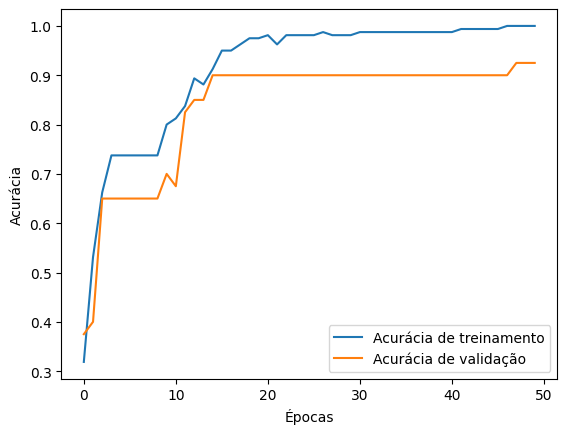

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN = model.predict(X_test)
y_pred_classes_ANN = np.argmax(y_pred_ANN, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes_ANN)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### Classificador SVM Dados Originais

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

SVM Classification Score is: 0.9


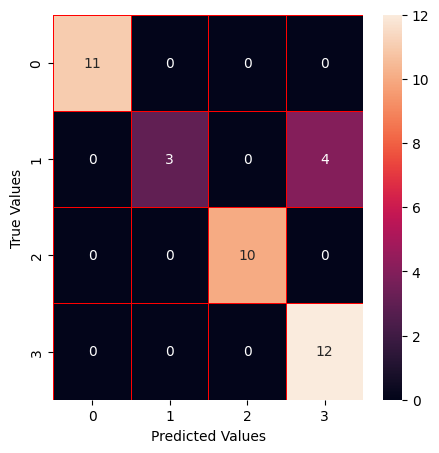

In [ ]:
method_names = []
method_scores = []
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(x_train,y_train)
print("SVM Classification Score is: {}".format(svm.score(x_test,y_test)))
method_names.append("SVM")
method_scores.append(svm.score(x_test,y_test))

#Confusion Matrix
y_pred = svm.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

<Axes: >

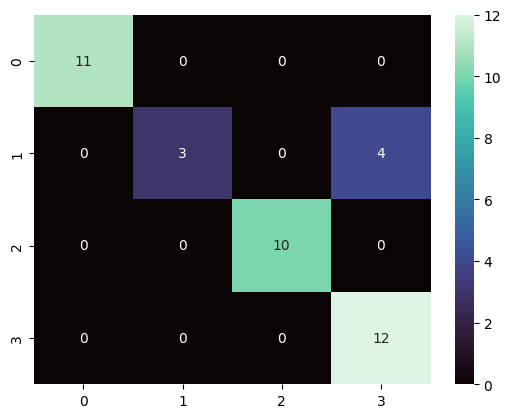

In [ ]:
import seaborn as sns
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['0', '1','2','3'],
                                 index=['0', '1','2','3'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

### Classificador KNN Dados Originais

Text(0, 0.5, 'score')

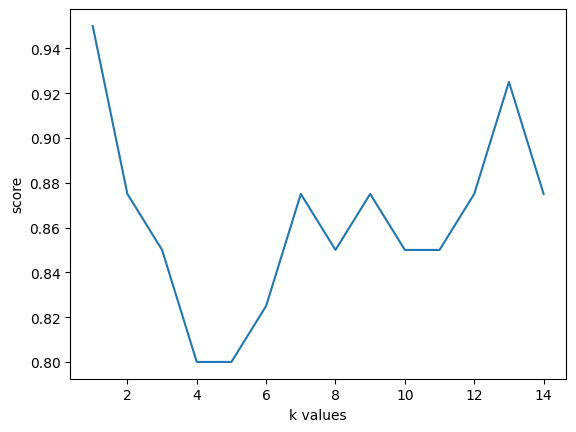

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
score_list=[]
for each in range(1,15):
    knn2 = KNeighborsClassifier(n_neighbors=each)
    knn2.fit(x_train,y_train)
    score_list.append(knn2.score(x_test,y_test))

plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("score")

Score for Number of Neighbors = 4: 0.8


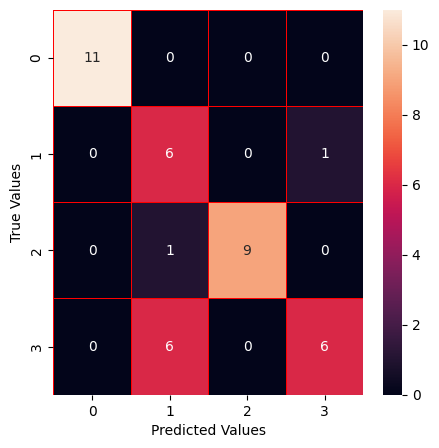

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
print("Score for Number of Neighbors = 4: {}".format(knn.score(x_test,y_test)))

#Confusion Matrix
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

### Transformador Dados, KDE, Wave




In [ ]:
def dividir_array_em_partes(array, num_partes):
    tamanho_parte = len(array) // num_partes
    partes = [array[i:i + tamanho_parte] for i in range(0, len(array), tamanho_parte)]
    return partes
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
def wavelet_denoising(x, wavelet='bior3.9', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def expandir_array(row):
    return pd.Series(row[0])

In [ ]:
import numpy as np
from scipy.fft import rfft, irfft, fft, ifft
from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
wave_mis = pd.DataFrame(dados_mis.iloc[:50,:].apply(wavelet_denoising,axis=1))
wave_unb = pd.DataFrame(dados_unb.iloc[:50,:].apply(wavelet_denoising,axis=1))

In [ ]:
wave_mis = wave_mis.apply(expandir_array, axis=1)
wave_unb = wave_unb.apply(expandir_array, axis=1)

In [ ]:
wave_mis.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_mis.csv', index=False)
wave_unb.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_unb.csv', index=False)

In [ ]:
def calculate_rfft(signal):
    signal = np.ascontiguousarray(signal)
    rfft_sig = rfft(signal)
    rfft_sig_abs = abs(rfft_sig)

    return rfft_sig,rfft_sig_abs

def apply_kde(signal_fft, bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(signal_fft[:, None])
    return kde

def grid_search_bandwidth(signal_fft, bandwidth_range):
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidth_range},
                        cv=5)  # 5-fold cross-validation
    grid.fit(signal_fft[:, None])
    return grid.best_params_['bandwidth']

def find_threshold(signal_fft, kde):
    log_density = kde.score_samples(signal_fft[:, None])
    density = np.exp(log_density)
    # Find peaks based on KDE density
    peaks, _ = find_peaks(density)
    return peaks

def filter_signal(signal_fft, peaks):
    filtered_fft = np.zeros_like(signal_fft)
    filtered_fft[peaks] = signal_fft[peaks]
    return filtered_fft

In [ ]:
def main(signal):
    # Calculate the rFFT of the signal
    signal_fft = calculate_rfft(signal)

    # Grid search to find the best bandwidth
    #bandwidth_range = np.linspace(5, 10, 50)
    #best_bandwidth = grid_search_bandwidth(signal_fft[1], bandwidth_range)
    #print(best_bandwidth)

    # Apply KDE with the best bandwidth
    kde = apply_kde(signal_fft[1], 9)

    # Find the best threshold for separating peaks and noise
    peaks = find_threshold(signal_fft[1], kde)


    # Filter the signal by keeping only the peaks
    filtered_fft = filter_signal(signal_fft[0], peaks)

    # Perform inverse FFT to get back to time domain
    filtered_signal = irfft(filtered_fft)

    #filtered_data = []

    #for i in range(len(filtered_signal) - 3 + 1):
    #  window = filtered_signal[i:i+3]
    #  median = np.median(window)
    #  filtered_data.append(median)

    return filtered_signal

In [ ]:
mis_filtrado_KDE = pd.DataFrame()
#filtered_data = []
for i in range(50):
  arranjo = dados_mis.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,50)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(main,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  #div_fil_memdian = divisao_filtrada_df.apply(median_filter, axis=1)
  #div_fil_memdian_df = pd.DataFrame(div_fil_memdian)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  mis_filtrado_KDE = pd.concat([mis_filtrado_KDE,df_transformado])

In [ ]:
mis_filtrado_KDE.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/KDE_mis.csv', index=False)

In [ ]:
mis_filtrado_KDE_Wave = pd.DataFrame()
#filtered_data = []
for i in range(50):
  arranjo = wave_mis.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,50)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(main,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  #div_fil_memdian = divisao_filtrada_df.apply(median_filter, axis=1)
  #div_fil_memdian_df = pd.DataFrame(div_fil_memdian)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  mis_filtrado_KDE_Wave = pd.concat([mis_filtrado_KDE_Wave,df_transformado])

In [ ]:
mis_filtrado_KDE_Wave.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_KDE_mis.csv', index=False)

In [ ]:
unb_filtrado_KDE = pd.DataFrame()
#filtered_data = []
for i in range(50):
  arranjo = dados_unb.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,50)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(main,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  #div_fil_memdian = divisao_filtrada_df.apply(median_filter, axis=1)
  #div_fil_memdian_df = pd.DataFrame(div_fil_memdian)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  unb_filtrado_KDE = pd.concat([unb_filtrado_KDE,df_transformado])

In [ ]:
unb_filtrado_KDE.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/KDE_unb.csv', index=False)

In [ ]:
unb_filtrado_KDE_Wave = pd.DataFrame()
#filtered_data = []
for i in range(50):
  arranjo = dados_unb.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,50)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(main,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  #div_fil_memdian = divisao_filtrada_df.apply(median_filter, axis=1)
  #div_fil_memdian_df = pd.DataFrame(div_fil_memdian)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  unb_filtrado_KDE_Wave = pd.concat([unb_filtrado_KDE_Wave,df_transformado])

In [ ]:
unb_filtrado_KDE_Wave.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_KDE_unb.csv', index=False)

### Feature Dados Wave

In [ ]:
fft_normal_wave = pd.DataFrame(FFT(wave_normal.iloc[:50]))
fft_bea_wave = pd.DataFrame(FFT(wave_bea.iloc[:50]))
fft_mis_wave = pd.DataFrame(FFT(wave_mis.iloc[:50]))
fft_unb_wave = pd.DataFrame(FFT(wave_unb.iloc[:50]))
data_merged_wave = pd.concat((fft_normal_wave, fft_bea_wave,fft_mis_wave,fft_unb_wave))
def NormalizeDataWave(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged_wave)
    data_min = np.min(data_merged_wave)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))
fft_normal_norm_wave = NormalizeDataWave(fft_normal_wave)
fft_bea_norm_wave = NormalizeDataWave(fft_bea_wave)
fft_mis_norm_wave = NormalizeDataWave(fft_mis_wave)
fft_unb_norm_wave = NormalizeDataWave(fft_unb_wave)
media_normal_wave = mean(fft_normal_norm_wave)
media_bea_wave = mean(fft_bea_norm_wave)
media_mis_wave = mean(fft_mis_norm_wave)
media_unb_wave = mean(fft_unb_norm_wave)
rms_normal_wave = rms(fft_normal_norm_wave)
rms_bea_wave = rms(fft_bea_norm_wave)
rms_mis_wave = rms(fft_mis_norm_wave)
rms_unb_wave = rms(fft_unb_norm_wave)
pp_normal_wave = pp(fft_normal_norm_wave)
pp_bea_wave = pp(fft_bea_norm_wave)
pp_mis_wave = pp(fft_mis_norm_wave)
pp_unb_wave = pp(fft_unb_norm_wave)
feat_normal_wave = pd.concat((media_normal_wave, pp_normal_wave, rms_normal_wave), axis=1)
feat_bea_wave = pd.concat((media_bea_wave, pp_bea_wave, rms_bea_wave), axis=1)
feat_mis_wave = pd.concat((media_mis_wave, pp_mis_wave, rms_mis_wave), axis=1)
feat_unb_wave = pd.concat((media_unb_wave, pp_unb_wave, rms_unb_wave), axis=1)
feat_normal_wave.columns = ['media', 'pp', 'rms']
feat_bea_wave.columns = ['media', 'pp', 'rms']
feat_mis_wave.columns = ['media', 'pp', 'rms']
feat_unb_wave.columns = ['media', 'pp', 'rms']
feat_normal_wave['cond']=0
feat_bea_wave['cond']=1
feat_mis_wave['cond']=2
feat_unb_wave['cond']=3
matriz_wave_classificacao = pd.concat((feat_normal_wave, feat_bea_wave, feat_mis_wave, feat_unb_wave))

### Classificação Wave ANN

In [ ]:
X_wave = matriz_wave_classificacao.drop('cond', axis=1)
y_wave = matriz_wave_classificacao['cond']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_wave, y_wave, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
16/16 [==============================] - 1s 16ms/step - loss: 1.3548 - accuracy: 0.3562 - val_loss: 1.3087 - val_accuracy: 0.3750
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 1.1881 - accuracy: 0.5250 - val_loss: 1.1695 - val_accuracy: 0.4000
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 1.0527 - accuracy: 0.6625 - val_loss: 1.0683 - val_accuracy: 0.7000
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.9452 - accuracy: 0.7375 - val_loss: 0.9847 - val_accuracy: 0.6750
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.8504 - accuracy: 0.7375 - val_loss: 0.9019 - val_accuracy: 0.6750
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.7679 - accuracy: 0.7375 - val_loss: 0.8317 - val_accuracy: 0.6750
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.7375 - val_loss: 0.7625 - val_accuracy: 0.6500
Epoch 8/50
16/16 [=

2/2 [==============================] - 0s 9ms/step
Acurácia: 1.00
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Matriz de confusão:
[[ 6  0  0  0]
 [ 0 15  0  0]
 [ 0  0  9  0]
 [ 0  0  0 10]]


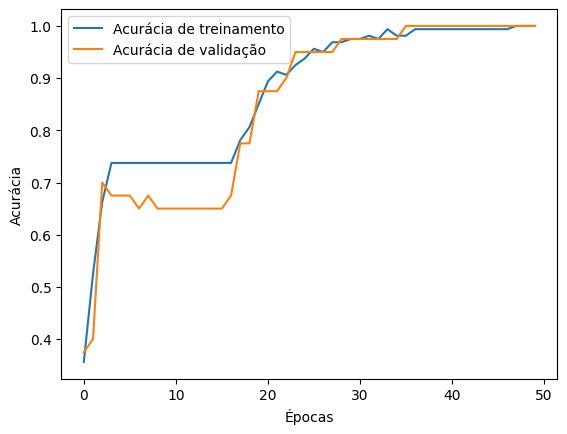

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN = model.predict(X_test)
y_pred_classes_ANN = np.argmax(y_pred_ANN, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes_ANN)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### Classificador SVM Wave

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_wave, y_wave, test_size=0.2, random_state=0)
# Apply SVM Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc=SVC(kernel='rbf')
svc.fit(x_train, y_train)
y_pred=svc.predict(x_test)
print('Model accuracy : {0:0.3f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy : 0.900


<Axes: >

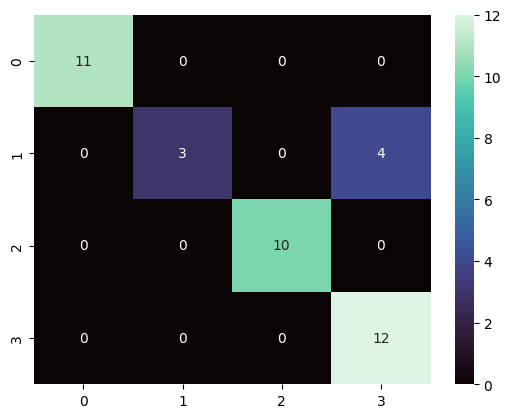

In [ ]:
import seaborn as sns
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['0', '1','2','3'],
                                 index=['0', '1','2','3'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

### Classificador KNN Wave

Text(0, 0.5, 'score')

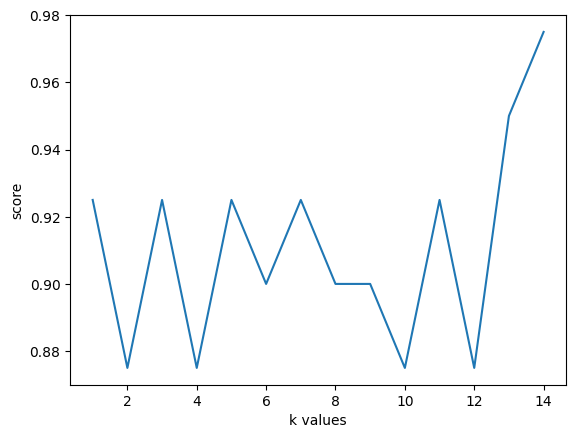

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_wave, y_wave, test_size=0.2, random_state=0)
from sklearn.neighbors import KNeighborsClassifier
score_list=[]
for each in range(1,15):
    knn2 = KNeighborsClassifier(n_neighbors=each)
    knn2.fit(x_train,y_train)
    score_list.append(knn2.score(x_test,y_test))

plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("score")

Score for Number of Neighbors = 2: 0.875


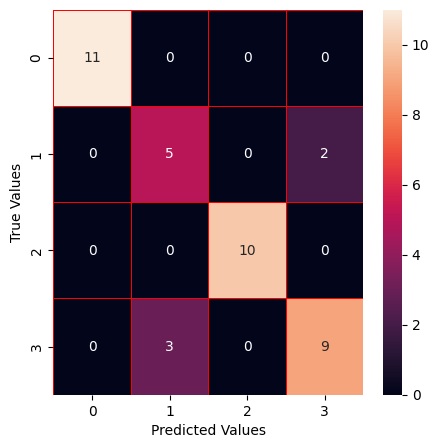

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
print("Score for Number of Neighbors = 2: {}".format(knn.score(x_test,y_test)))

#Confusion Matrix
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

### Feature Dados KDE

In [ ]:
fft_normal_KDE = pd.DataFrame(FFT(KDE_normal.iloc[:50]))
fft_bea_KDE = pd.DataFrame(FFT(KDE_bea.iloc[:50]))
fft_mis_KDE = pd.DataFrame(FFT(mis_filtrado_KDE.iloc[:50]))
fft_unb_KDE = pd.DataFrame(FFT(unb_filtrado_KDE.iloc[:50]))
data_merged_KDE = pd.concat((fft_normal_KDE, fft_bea_KDE,fft_mis_KDE,fft_unb_KDE))
def NormalizeDataKDE(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged_KDE)
    data_min = np.min(data_merged_KDE)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))
fft_normal_norm_KDE = NormalizeDataKDE(fft_normal_KDE)
fft_bea_norm_KDE = NormalizeDataKDE(fft_bea_KDE)
fft_mis_norm_KDE = NormalizeDataKDE(fft_mis_KDE)
fft_unb_norm_KDE = NormalizeDataKDE(fft_unb_KDE)
media_normal_KDE = mean(fft_normal_norm_KDE)
media_bea_KDE = mean(fft_bea_norm_KDE)
media_mis_KDE = mean(fft_mis_norm_KDE)
media_unb_KDE = mean(fft_unb_norm_KDE)
rms_normal_KDE = rms(fft_normal_norm_KDE)
rms_bea_KDE = rms(fft_bea_norm_KDE)
rms_mis_KDE = rms(fft_mis_norm_KDE)
rms_unb_KDE = rms(fft_unb_norm_KDE)
pp_normal_KDE = pp(fft_normal_norm_KDE)
pp_bea_KDE = pp(fft_bea_norm_KDE)
pp_mis_KDE = pp(fft_mis_norm_KDE)
pp_unb_KDE = pp(fft_unb_norm_KDE)
feat_normal_KDE = pd.concat((media_normal_KDE, pp_normal_KDE, rms_normal_KDE), axis=1)
feat_bea_KDE = pd.concat((media_bea_KDE, pp_bea_KDE, rms_bea_KDE), axis=1)
feat_mis_KDE = pd.concat((media_mis_KDE, pp_mis_KDE, rms_mis_KDE), axis=1)
feat_unb_KDE = pd.concat((media_unb_KDE, pp_unb_KDE, rms_unb_KDE), axis=1)
feat_normal_KDE.columns = ['media', 'pp', 'rms']
feat_bea_KDE.columns = ['media', 'pp', 'rms']
feat_mis_KDE.columns = ['media', 'pp', 'rms']
feat_unb_KDE.columns = ['media', 'pp', 'rms']
feat_normal_KDE['cond']=0
feat_bea_KDE['cond']=1
feat_mis_KDE['cond']=2
feat_unb_KDE['cond']=3
matriz_KDE_classificacao = pd.concat((feat_normal_KDE, feat_bea_KDE, feat_mis_KDE, feat_unb_KDE))

### CLassificador ANN para KDE

In [ ]:
X_KDE = matriz_KDE_classificacao.drop('cond', axis=1)
y_KDE = matriz_KDE_classificacao['cond']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_KDE, y_KDE, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
16/16 [==============================] - 1s 16ms/step - loss: 1.3812 - accuracy: 0.3875 - val_loss: 1.3602 - val_accuracy: 0.4750
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 1.2622 - accuracy: 0.5312 - val_loss: 1.2359 - val_accuracy: 0.4750
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 1.1593 - accuracy: 0.5437 - val_loss: 1.1318 - val_accuracy: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0861 - accuracy: 0.5437 - val_loss: 1.0505 - val_accuracy: 0.5500
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0312 - accuracy: 0.5437 - val_loss: 0.9868 - val_accuracy: 0.5500
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 0.9910 - accuracy: 0.5437 - val_loss: 0.9418 - val_accuracy: 0.5750
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.9610 - accuracy: 0.5437 - val_loss: 0.9081 - val_accuracy: 0.5750
Epoch 8/50
16/16 [=

2/2 [==============================] - 0s 6ms/step
Acurácia: 0.72
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.80      0.89        15
           2       0.40      0.44      0.42         9
           3       0.58      0.70      0.64        10

    accuracy                           0.73        40
   macro avg       0.75      0.74      0.74        40
weighted avg       0.76      0.72      0.74        40

Matriz de confusão:
[[ 6  0  0  0]
 [ 0 12  3  0]
 [ 0  0  4  5]
 [ 0  0  3  7]]


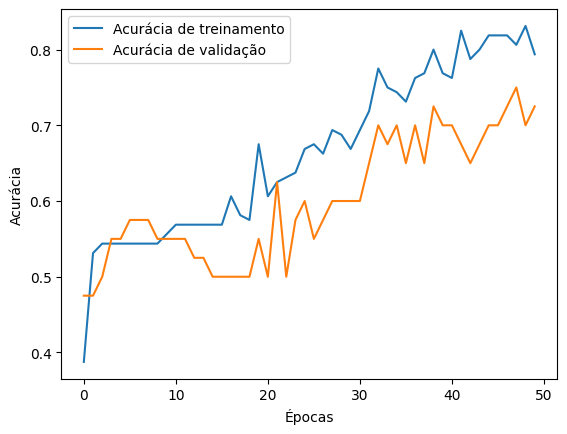

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN = model.predict(X_test)
y_pred_classes_ANN = np.argmax(y_pred_ANN, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes_ANN)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### Classificador SVM para KDE

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_KDE, y_KDE, test_size=0.2, random_state=0)
# Apply SVM Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc=SVC(kernel='rbf')
svc.fit(x_train, y_train)
y_pred=svc.predict(x_test)
print('Model accuracy : {0:0.3f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy : 0.750


### Classificador KNN para KDE

Score for Number of Neighbors = 2: 0.8


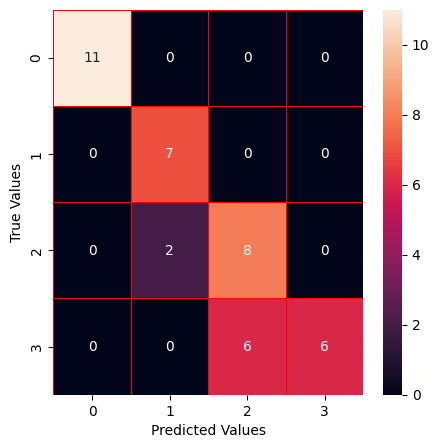

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
print("Score for Number of Neighbors = 2: {}".format(knn.score(x_test,y_test)))

#Confusion Matrix
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

### Feature Dados KDE + Wave

In [ ]:
fft_normal_KDE_wave = pd.DataFrame(FFT(Wave_KDE_normal.iloc[:50]))
fft_bea_KDE_wave = pd.DataFrame(FFT(Wave_KDE_bea.iloc[:50]))
fft_mis_KDE_wave = pd.DataFrame(FFT(mis_filtrado_KDE_Wave.iloc[:50]))
fft_unb_KDE_wave = pd.DataFrame(FFT(unb_filtrado_KDE_Wave.iloc[:50]))

data_merged_KDE_Wave = pd.concat((fft_normal_KDE_wave, fft_bea_KDE_wave,fft_mis_KDE_wave,fft_unb_KDE_wave))
def NormalizeDataKDEWave(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged_KDE)
    data_min = np.min(data_merged_KDE)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))
fft_normal_norm_KDE_wave = NormalizeDataKDEWave(fft_normal_KDE_wave)
fft_bea_norm_KDE_wave = NormalizeDataKDEWave(fft_bea_KDE_wave)
fft_mis_norm_KDE_wave = NormalizeDataKDEWave(fft_mis_KDE_wave)
fft_unb_norm_KDE_wave = NormalizeDataKDEWave(fft_unb_KDE_wave)

media_normal_KDE_Wave = mean(fft_normal_norm_KDE_wave)
media_bea_KDE_Wave = mean(fft_bea_norm_KDE_wave)
media_mis_KDE_Wave = mean(fft_mis_norm_KDE_wave)
media_unb_KDE_Wave = mean(fft_unb_norm_KDE_wave)

rms_normal_KDE_wave = rms(fft_normal_norm_KDE_wave)
rms_bea_KDE_wave = rms(fft_bea_norm_KDE_wave)
rms_mis_KDE_wave = rms(fft_mis_norm_KDE_wave)
rms_unb_KDE_wave = rms(fft_unb_norm_KDE_wave)

pp_normal_KDE_wave = pp(fft_normal_norm_KDE_wave)
pp_bea_KDE_wave = pp(fft_bea_norm_KDE_wave)
pp_mis_KDE_wave = pp(fft_mis_norm_KDE_wave)
pp_unb_KDE_wave = pp(fft_unb_norm_KDE_wave)

feat_normal_KDE_wave = pd.concat((media_normal_KDE_Wave, pp_normal_KDE_wave, rms_normal_KDE_wave), axis=1)
feat_bea_KDE_wave = pd.concat((media_bea_KDE_Wave, pp_bea_KDE_wave, rms_bea_KDE_wave), axis=1)
feat_mis_KDE_wave = pd.concat((media_mis_KDE_Wave, pp_mis_KDE_wave, rms_mis_KDE_wave), axis=1)
feat_unb_KDE_wave = pd.concat((media_unb_KDE_Wave, pp_unb_KDE_wave, rms_unb_KDE_wave), axis=1)
feat_normal_KDE_wave.columns = ['media', 'pp', 'rms']
feat_bea_KDE_wave.columns = ['media', 'pp', 'rms']
feat_mis_KDE_wave.columns = ['media', 'pp', 'rms']
feat_unb_KDE_wave.columns = ['media', 'pp', 'rms']
feat_normal_KDE_wave['cond']=0
feat_bea_KDE_wave['cond']=1
feat_mis_KDE_wave['cond']=2
feat_unb_KDE_wave['cond']=3
matriz_KDE_Wave_classificacao = pd.concat((feat_normal_KDE_wave, feat_bea_KDE_wave, feat_mis_KDE_wave, feat_unb_KDE_wave))

In [ ]:
X_KDE_wave = matriz_KDE_Wave_classificacao.drop('cond', axis=1)
y_KDE_wave = matriz_KDE_Wave_classificacao['cond']

In [ ]:
# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_KDE_wave, y_KDE_wave, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
16/16 [==============================] - 3s 25ms/step - loss: 1.1846 - accuracy: 0.5188 - val_loss: 1.0838 - val_accuracy: 0.5250
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0765 - accuracy: 0.5125 - val_loss: 0.9791 - val_accuracy: 0.5250
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0084 - accuracy: 0.5125 - val_loss: 0.9034 - val_accuracy: 0.5250
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.9597 - accuracy: 0.5125 - val_loss: 0.8495 - val_accuracy: 0.5250
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.9226 - accuracy: 0.5125 - val_loss: 0.8149 - val_accuracy: 0.5250
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.8970 - accuracy: 0.5188 - val_loss: 0.7928 - val_accuracy: 0.5250
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.8717 - accuracy: 0.5188 - val_loss: 0.7711 - val_accuracy: 0.5250
Epoch 8/50
16/16 [=

2/2 [==============================] - 0s 5ms/step
Acurácia: 0.95
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.87      0.93        15
           2       0.82      1.00      0.90         9
           3       1.00      1.00      1.00        10

    accuracy                           0.95        40
   macro avg       0.95      0.97      0.96        40
weighted avg       0.96      0.95      0.95        40

Matriz de confusão:
[[ 6  0  0  0]
 [ 0 13  2  0]
 [ 0  0  9  0]
 [ 0  0  0 10]]


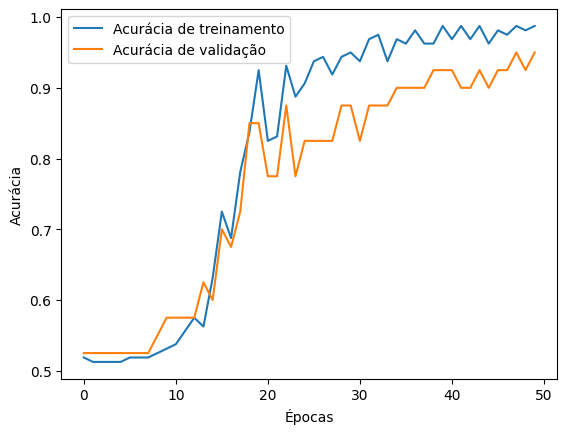

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN = model.predict(X_test)
y_pred_classes_ANN = np.argmax(y_pred_ANN, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes_ANN)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_KDE_wave, y_KDE_wave, test_size=0.2, random_state=0)
# Apply SVM Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc=SVC()
svc.fit(x_train, y_train)
y_pred=svc.predict(x_test)
print('Model accuracy : {0:0.3f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy : 0.750


Score for Number of Neighbors = 2: 0.825


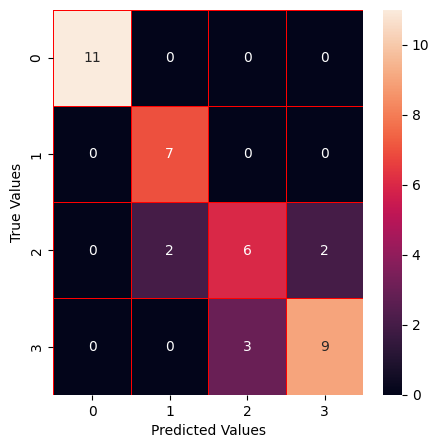

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
print("Score for Number of Neighbors = 2: {}".format(knn.score(x_test,y_test)))

#Confusion Matrix
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()